# Introduction

# Data Import

The section imports all the required libraries. Then, the required CSV files are loaded into variables for use throughout the notebook. There are three required CSV files.

`epi-training.csv` - contains the provided match data

`epl-teams.csv` - contains scraped team scores from [sofifa.com](https://sofifa.com)

`epl-test.csv` - contains the final test data

## Import libraries

In [57]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt

## Scraping tool

The scraping tool is stored in a separate python file, `fifa_scraper.py`. If the `epl-teams.csv` has not been generated, the scraper must be run. Configure the leagues for which to retrieve team scores by controlling the years variable, each year has a corresponding league ID which can be found on [sofifa.com](sofifa.com).

The team scores that are obtained are ratings from FIFA, which represent a measure of how popular and good each team is considered to be. This can be used to augment the training data.

The following ratings are collected

- **OA**: Overall score (0-100)
- **AT**: Attack score (0-100)
- **MD**: Midfield score (0-100)
- **DF**: Defense score (0-100)
- **CW**: Club worth (millions)


In [2]:
from fifa_scraper import scrape_premier_league_teams

years = [('240016', 2024), ('230054', 2023), ('220069', 2022), 
         ('210064', 2021), ('200061', 2020), ('190075', 2019), 
         ('180084', 2018), ('170099', 2017), ('160058', 2016), 
         ('150059', 2015), ('140052', 2014), ('130034', 2013)]

scrape_premier_league_teams(years)

## Data loading

Now, processing and loading all the required data. The match data is stored in `df` and the team scores are stored in `df_teams`. In following sections, the two features will be merged. 

In [73]:
root_dir = './' # ENTER YOUR WORKING DRIECTORY HERE #
epl_training_path = root_dir + 'epl-training.csv'
epl_teams_path = root_dir + 'epl-teams.csv'
epl_test_path = root_dir + 'epl-test.csv'

# Load and describe the csv file
df = pd.read_csv(epl_training_path)
df_teams = pd.read_csv(epl_teams_path)
df_test = pd.read_csv(epl_test_path)

### _Raw Training Data_
View the match data and verify content.

In [4]:
df.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
count,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000,8840.000000
mean,1.526471,1.162104,0.685068,0.510407,13.538688,10.704072,6.042421,4.720362,6.060294,4.768213,11.327149,11.810294,1.433371,1.762217,0.062557,0.086878
std,1.305033,1.147988,0.834895,0.725081,5.284536,4.623558,3.297777,2.772163,3.098943,2.732814,3.760777,3.940944,1.195967,1.276742,0.253141,0.293474
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,4.000000,3.000000,4.000000,3.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,6.000000,4.000000,6.000000,4.000000,11.000000,12.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,13.000000,8.000000,6.000000,8.000000,6.000000,14.000000,14.000000,2.000000,3.000000,0.000000,0.000000
max,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.000000,20.000000,19.000000,33.000000,29.000000,7.000000,9.000000,3.000000,2.000000


In [5]:
df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
8836,29/10/2023,West Ham,Everton,0.0,1.0,A,0.0,0.0,D,S Attwell,...,2.0,4.0,4.0,3.0,7.0,11.0,4.0,1.0,0.0,0.0
8837,29/10/2023,Aston Villa,Luton,3.0,1.0,H,1.0,0.0,H,J Brooks,...,6.0,1.0,6.0,4.0,11.0,10.0,3.0,2.0,0.0,0.0
8838,29/10/2023,Brighton,Fulham,1.0,1.0,D,1.0,0.0,H,M Salisbury,...,7.0,5.0,7.0,3.0,12.0,8.0,0.0,3.0,0.0,0.0
8839,29/10/2023,Liverpool,Nott'm Forest,3.0,0.0,H,2.0,0.0,H,C Salisbury,...,8.0,1.0,8.0,3.0,9.0,13.0,2.0,3.0,0.0,0.0
8840,29/10/2023,Man United,Man City,0.0,3.0,A,0.0,1.0,A,P Tierney,...,3.0,10.0,7.0,12.0,9.0,4.0,4.0,1.0,0.0,0.0


### _Raw Team Scores_
View the raw team scores and verify content

In [6]:
df_teams.tail()

,Team,Year,OA,AT,MD,DF,CW
235,Wigan,2013,74,72,72,33,27.18
236,Swansea,2013,74,73,73,33,25.82
237,Norwich,2013,72,73,73,33,26.27
238,Southampton,2013,73,74,71,33,23.91
239,Reading,2013,72,69,71,33,24.73


# Data Transformation and Exploration

## Data Cleaning

The section double checks the match data stored in `df` for any missing values and NaNs which might generate problems later on. All rows with NaN values are dropped. Additionally, only match data after 2013 is considered useful, as a decade of training examples is deemed to be sufficient to minimize bias in predictions. Too much match data might confuse the model with players in teams which do not play anymore.

`df_teams` need not be sanitized as it is sanitized by the scraper tool during the scraping process.

In [7]:
# Remove any row where the HomeTeam or AwayTeam is not a valid name
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.year >= 2013]

# Check that all invalid fields have been removed
assert(df['HomeTeam'].apply(lambda x: not isinstance(x, str)).sum() == 0)
assert(df['AwayTeam'].apply(lambda x: not isinstance(x, str)).sum() == 0)

df.describe()

/tmp/ipykernel_56836/3652481997.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
count,4082,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000,4082.000000
mean,2018-05-30 08:51:37.305242624,1.527438,1.220970,0.688143,0.543606,13.973052,11.386085,4.877266,4.021068,5.808427,4.697452,10.537727,10.902744,1.561979,1.761881,0.055120,0.072024
min,2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-10-17 00:00:00,1.000000,0.000000,0.000000,0.000000,10.000000,8.000000,3.000000,2.000000,4.000000,3.000000,8.000000,8.000000,1.000000,1.000000,0.000000,0.000000
50%,2018-04-19 00:00:00,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,5.000000,4.000000,5.000000,4.000000,10.000000,11.000000,1.000000,2.000000,0.000000,0.000000
75%,2021-02-10 00:00:00,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,6.000000,5.000000,8.000000,6.000000,13.000000,13.000000,2.000000,3.000000,0.000000,0.000000
max,2023-12-08 00:00:00,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,20.000000,20.000000,19.000000,19.000000,24.000000,26.000000,7.000000,9.000000,2.000000,2.000000
std,NaN,1.318393,1.189957,0.848194,0.751497,5.660514,4.909910,2.781054,2.395689,3.099675,2.703758,3.391858,3.546809,1.227275,1.271765,0.236675,0.268781


This results in roughly half of the match data being discarded. However, 4082 matchs is sufficient examples for the model to achieve good performance.

## Encoding classes as labels

To encode classes as labels, the `LabelEncoder` from sklearn is used. There are two primary pieces of class information, namely the team names and the final result. The team names in `df_teams` is already standardized with the names used in the match data, thus the same `LabelEncoder` can be used in both cases.

In [8]:
# Instantiate LabelEncoder
team_encoder = LabelEncoder()

# Fit and transform the 'Names' column with LabelEncoder
team_encoder = team_encoder.fit(df['HomeTeam'])
df['HomeTeamLabel'] = team_encoder.transform(df['HomeTeam'])
df['AwayTeamLabel'] = team_encoder.transform(df['AwayTeam'])
df_teams['TeamLabel'] = team_encoder.transform(df_teams['Team'])

print(f"Team Names: {team_encoder.classes_}")

Team Names: ['Arsenal' 'Aston Villa' 'Bournemouth' 'Brentford' 'Brighton' 'Burnley'
 'Cardiff' 'Chelsea' 'Crystal Palace' 'Everton' 'Fulham' 'Huddersfield'
 'Hull' 'Leeds' 'Leicester' 'Liverpool' 'Luton' 'Man City' 'Man United'
 'Middlesbrough' 'Newcastle' 'Norwich' "Nott'm Forest" 'QPR' 'Reading'
 'Sheffield United' 'Southampton' 'Stoke' 'Sunderland' 'Swansea'
 'Tottenham' 'Watford' 'West Brom' 'West Ham' 'Wigan' 'Wolves']


In [9]:
result_encoder = LabelEncoder()
result_encoder = result_encoder.fit(df['FTR'])
df['FTRLabel'] = result_encoder.transform(df['FTR'])
df['HTRLabel'] = result_encoder.transform(df['HTR'])

print(f"Result names: {result_encoder.classes_}")

Result names: ['A' 'D' 'H']


## Analyzing home team advantage

Looking at the data, it is possible to calculate the probability of a home team winning, against the away team winning, against a draw. It is clear that the home team is more likely to win as compared to the away team, showing the existence of home team advantage. 

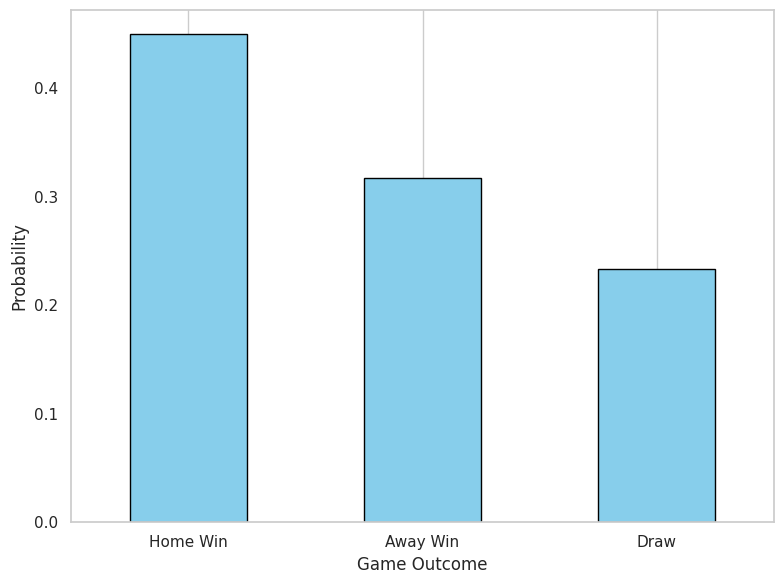

In [10]:
ftr_counts = df['FTR'].value_counts(normalize=True) # Normalize to convert to probabilities

plt.figure(figsize=(8, 6))
ftr_counts.plot(kind='bar', edgecolor='black')
plt.xlabel('Game Outcome')
plt.ylabel('Probability')
plt.xticks(range(len(ftr_counts)), ['Home Win', 'Away Win', 'Draw'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Combined match data and team scores

The following snippet of code combines the data from each match and the team scores. While doing so, it performs data transformation on the match data to make it more suitable for future training.

### _Feature engineering from match data_

One concern with the match data in its current form, is that a process must be developed to rollup historical match data into a feature vector which can be used to classify the next result. A naive implementation might just use the features of the immediately preceeding home and away game, but a better approach would include the historial data of the team.

The **Dixon-Coles model**, uses a poisson distribution to model the goal likelihood of the home and away teams, to make predictions on game outcomes. Two key contributions the model made to the basic possion model is to add a correction term for low-frequency matches (games with 0-0, 0-1, 1-0, and 1-1) outcomes, and to add a exponential time weighting component to more strongly consider recent matches than old matches.

The second element is of concern to use in the feature engineering stage. By applying an exponential weighted average to columns, a feature can be constructed for each column in the match data. The features can be precomputed like follows:

In [11]:
home_columns = ['FTHG', 'HTHG', 'HS', 'HST', 'HF', 'HC', 'HY', 'HR']
away_columns = ['FTAG', 'HTAG', 'AS', 'AST', 'AF', 'AC', 'AY', 'AR']
team_columns_single = ['OA', 'AT', 'MD', 'DF', 'CW']
team_columns = ['HOA', 'HAT', 'HMD', 'HDF', 'HCW', 'AOA', 'AAT', 'AMD', 'ADF', 'ACW']

td = pd.Timedelta(days=365) # Adjust for exponential weighting

# Precomputing features
precomputed_features = {}

for team in team_encoder.classes_:
    #  Calculating the Home features
    df_home = df[df['HomeTeam'] == team]
    df_home = df_home[['Date', *home_columns]]

    # Applying the exponential weighting mean
    df_home[home_columns] = df_home[home_columns].ewm(times=df_home['Date'], halflife=td).mean()
    precomputed_features[team] = {}
    precomputed_features[team]['Home'] = df_home
    
    # Calculating the Away features
    df_away = df[df['AwayTeam'] == team]
    df_away = df_away[['Date', *away_columns]]

    # Applying the exponential weighting mean
    df_away[away_columns] = df_away[away_columns].ewm(times=df_away['Date'], halflife=td).mean()
    precomputed_features[team]['Away'] = df_away


### _Merging match data with team scores_

To construct the final feature matrix, the transformed match data must be merged with the team scores. For each match, a feature is constructed by taking the exponential weighted mean up to the previous match, and the home and away team scores for that league is appended to the feature.

Even though the data starts from 2013, the 2013 league is excluded from the feature set, as there is not much history for the teams to be computed. Thus, leagues starting from 2014 are seen in the final features, while using the 2013 league data to calculate those features.

The team scores are assumed to be constant throughout a league.

In [12]:
# List to store league date ranges
league_dates = []

# Loop through the years from 2013 to 2023
for year in range(2014, 2023 + 1):
    # Define the start and end dates for each league year (assuming August 1 to June 1)
    start_date = f"{year}-08-01"
    end_date = f"{year + 1}-06-01"
    
    # Append the start and end dates as a tuple to the league_dates list
    league_dates.append((start_date, end_date, year))

feature_columns = ['Date', 'League', 'HomeTeam', 'AwayTeam', *home_columns, *away_columns, *team_columns, 'FTRLabel']
df_features = pd.DataFrame(columns=feature_columns)
feature_list = []

for start, end, year in league_dates:
    print(f"{start} : {end}")
    league = df[(df['Date'] >= start) & (df['Date'] <= end)]
    
    for index in range(len(league)):
        row = league.iloc[index]
        home =  precomputed_features[row['HomeTeam']]['Home']
        home = home[home['Date'] < row['Date']]
        if home.empty:
            continue
        else:
            home = home.iloc[-1]

        # Check if ratings exist for the year
        home_team = df_teams[df_teams['Team'] == row['HomeTeam']]
        home_team = home_team[home_team['Year'] == year]

        # Else use the latest one
        if home_team.empty:
            home_team = df_teams[df_teams['Team'] == row['HomeTeam']]
            home_team = home_team[home_team['Year'] < year]
            # Else use sensible default team stats
            if home_team.empty:
                home_team = pd.DataFrame([[60, 60, 60, 60, 1]], columns=team_columns_single) # Defaults
                home_team = home_team.iloc[0]
            else:
                home_team = home_team.iloc[0]
        else:
            home_team = home_team.iloc[0]

        away =  precomputed_features[row['AwayTeam']]['Away']
        away = away[away['Date'] < row['Date']]
        if away.empty:
            continue
        else:
            away = away.iloc[-1]

        # Check if ratings exist for the year
        away_team = df_teams[df_teams['Team'] == row['AwayTeam']]
        away_team = away_team[away_team['Year'] == year]

        # Else use the latest one
        if away_team.empty:
            away_team = df_teams[df_teams['Team'] == row['AwayTeam']]
            away_team = away_team[away_team['Year'] < year]
            if away_team.empty:
                # Else use sensible default team stats
                away_team = pd.DataFrame([[60, 60, 60, 60, 1]], columns=team_columns_single) # Defaults
                away_team = away_team.iloc[0]
            else:
                away_team = away_team.iloc[0]
        else:
            away_team = away_team.iloc[0]

        feature_list.append([row['Date'], year, row['HomeTeam'], row['AwayTeam'],
                            *home[home_columns], *away[away_columns],
                            *home_team[team_columns_single], *away_team[team_columns_single], row['FTRLabel']])

df_features = pd.DataFrame(feature_list, columns=feature_columns)
df_features.tail()

2014-08-01 : 2015-06-01
2015-08-01 : 2016-06-01
2016-08-01 : 2017-06-01
2017-08-01 : 2018-06-01
2018-08-01 : 2019-06-01
2019-08-01 : 2020-06-01
2020-08-01 : 2021-06-01
2021-08-01 : 2022-06-01
2022-08-01 : 2023-06-01
2023-08-01 : 2024-06-01


,Date,League,HomeTeam,AwayTeam,FTHG,HTHG,HS,HST,HF,HC,...,HAT,HMD,HDF,HCW,AOA,AAT,AMD,ADF,ACW,FTRLabel
3272,2023-10-29,2023,West Ham,Everton,1.578128,0.848829,12.619655,4.346304,8.746408,5.595840,...,79,78,32,28.73,77,76,76,28,26.73,0
3273,2023-10-29,2023,Aston Villa,Luton,1.982285,0.928982,12.956715,4.992861,10.862901,5.127724,...,78,79,32,26.55,60,60,60,60,1.00,2
3274,2023-10-29,2023,Brighton,Fulham,1.702268,0.691698,16.992153,5.667728,11.228103,7.024878,...,77,78,28,27.18,79,76,75,31,27.45,1
3275,2023-10-29,2023,Liverpool,Nott'm Forest,2.391398,1.078043,18.829833,6.333001,10.251889,7.464952,...,81,85,33,26.55,75,76,77,33,26.09,2
3276,2023-10-29,2023,Man United,Man City,1.778197,0.719425,16.686185,5.925630,10.651029,6.197972,...,84,81,33,26.91,85,87,83,26,27.73,0


## Plot the correlation matrix

It is unsurprising if many of the features in the augmented feature set are redundant, as many factors of matches are correlated. For example, the Half Time goals is correlated to the full time goals for both the home and away team. It is worth getting an idea of which features are correlated to which other features to aid in feature selection, and to help preserve conditional probability assumptions.

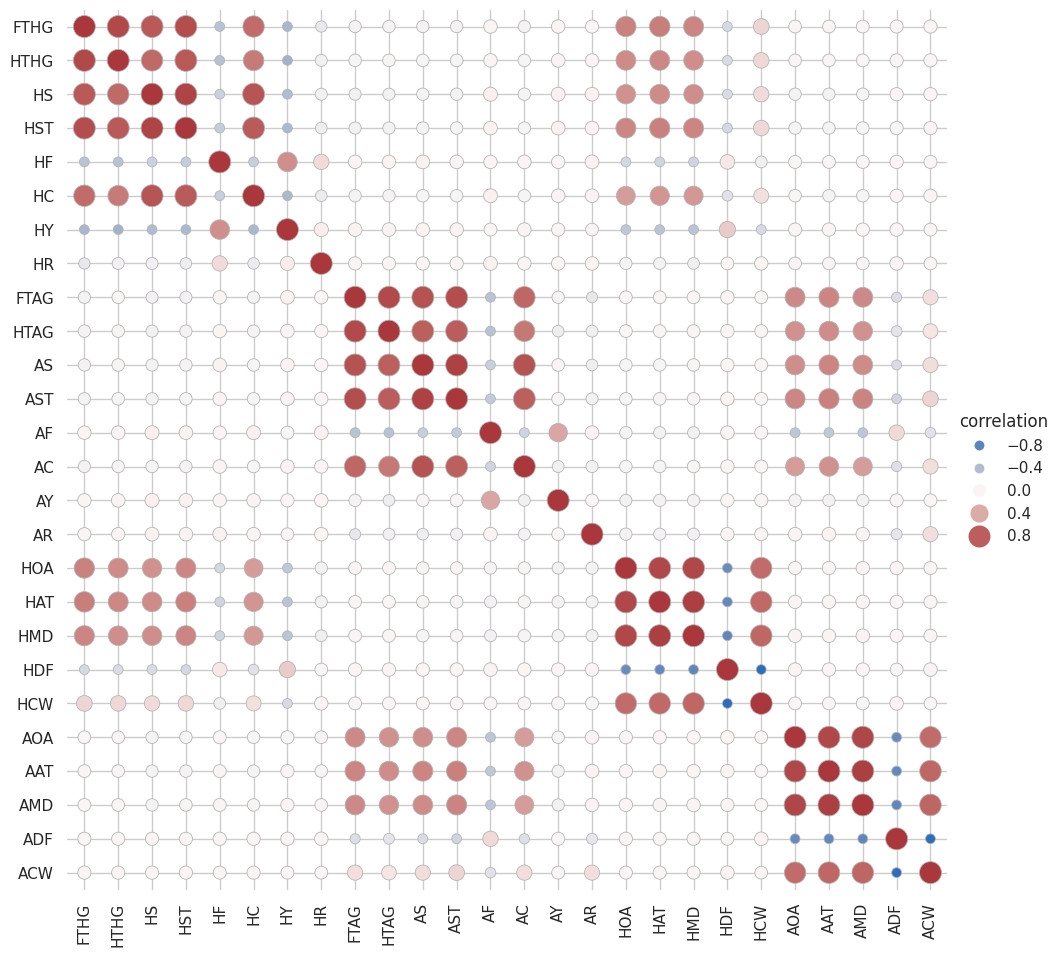

In [13]:
corr_mat = df_features[[*home_columns, *away_columns, *team_columns]].corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

# Methodology Overview

## Train-test split

The performance of teams in leagues is expected to vary through the duration of a league. This could be due to tiredness, loss of morale and other factors. Therefore, the performance of any model could vary significantly during a league.

Thus, the test setup of models must consider this fact, and entire leagues must be set aside for testing. In this study, the years 2013-2019, are considered training data and 2020 onwards is considered test data. Within the training data, **5-fold cross validation** shall be used for hyperparameter tuning. The data is split as follows.

- Training Set: 2107 matches (64.3%)
- Test Set: 1170 matches (35.7%)

In [44]:
df_features_train = df_features[df_features['League'] <= 2019] # Train on everything before and including 2019
df_features_train.describe()

,Date,League,FTHG,HTHG,HS,HST,HF,HC,HY,HR,...,HAT,HMD,HDF,HCW,AOA,AAT,AMD,ADF,ACW,FTRLabel
count,2107,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,...,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000,2107.000000
mean,2017-05-22 15:02:49.150450688,2016.416232,1.538651,0.692903,14.258338,4.855603,10.575764,5.906238,1.555725,0.057255,...,76.141908,75.307546,34.804461,24.581576,76.785002,76.170384,75.327005,34.824869,24.570522,1.154722
min,2014-08-02 00:00:00,2014.000000,0.610386,0.142091,8.706400,2.578009,7.971109,3.759759,0.803353,0.000000,...,60.000000,60.000000,31.000000,1.000000,60.000000,60.000000,60.000000,31.000000,1.000000,0.000000
25%,2015-12-16 12:00:00,2015.000000,1.195806,0.517255,12.439976,3.933715,9.910125,5.129112,1.357885,0.025055,...,74.000000,74.000000,33.000000,25.360000,75.000000,74.000000,74.000000,33.000000,25.270000,0.000000
50%,2017-05-04 00:00:00,2016.000000,1.436346,0.651508,13.531188,4.457389,10.583575,5.765324,1.567904,0.054381,...,76.000000,76.000000,33.000000,26.360000,77.000000,77.000000,76.000000,33.000000,26.360000,1.000000
75%,2018-11-05 12:00:00,2018.000000,1.814481,0.863472,15.906806,5.692651,11.187616,6.600197,1.727813,0.084052,...,80.000000,79.000000,33.000000,27.180000,81.000000,80.000000,79.000000,33.000000,27.180000,2.000000
max,2020-05-12 00:00:00,2019.000000,2.961918,1.386517,19.869059,8.191538,13.786748,8.810145,2.590556,0.239103,...,88.000000,83.000000,60.000000,28.910000,86.000000,88.000000,83.000000,60.000000,28.910000,2.000000
std,NaN,1.666377,0.468022,0.229730,2.457426,1.202155,0.979335,1.003611,0.285787,0.040284,...,5.691356,5.312133,6.884457,6.540764,6.104954,5.711812,5.306990,6.903155,6.565842,0.859437


In [45]:
df_features_test = df_features[df_features['League'] > 2019] # Test on 2019 and onwards
df_features_test.describe()

,Date,League,FTHG,HTHG,HS,HST,HF,HC,HY,HR,...,HAT,HMD,HDF,HCW,AOA,AAT,AMD,ADF,ACW,FTRLabel
count,1170,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,...,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000
mean,2022-03-05 19:21:50.769230848,2021.187179,1.510327,0.694168,13.582844,4.698056,10.566343,5.647180,1.584226,0.050749,...,77.964103,77.082906,33.713675,24.945026,78.382906,78.018803,77.121368,33.733333,24.952624,1.085470
min,2020-08-02 00:00:00,2020.000000,0.524966,0.000000,8.587495,1.000000,8.000000,2.420781,0.688624,0.000000,...,60.000000,60.000000,26.000000,1.000000,60.000000,60.000000,60.000000,26.000000,1.000000,0.000000
25%,2021-04-02 06:00:00,2020.000000,1.139111,0.507404,12.072652,3.981355,10.086333,5.001091,1.366355,0.026334,...,76.000000,75.000000,33.000000,25.090000,76.000000,76.000000,75.000000,33.000000,25.180000,0.000000
50%,2022-02-11 12:00:00,2021.000000,1.386076,0.658779,12.889692,4.455995,10.586098,5.496791,1.610005,0.045408,...,78.000000,77.000000,33.000000,25.910000,78.000000,78.000000,77.000000,33.000000,25.910000,1.000000
75%,2023-01-04 00:00:00,2022.000000,1.770501,0.832982,14.597008,5.380245,11.129518,6.167823,1.732630,0.072147,...,81.000000,80.000000,33.000000,26.820000,82.000000,81.000000,80.000000,33.000000,26.820000,2.000000
max,2023-12-08 00:00:00,2023.000000,3.115968,1.506966,19.448795,7.132187,13.331884,9.000000,4.206783,0.188465,...,87.000000,86.000000,60.000000,29.180000,89.000000,87.000000,86.000000,60.000000,29.180000,2.000000
std,NaN,0.982310,0.504115,0.255041,2.277716,1.003257,0.898720,0.990072,0.330028,0.035321,...,5.138833,4.825169,5.789956,5.310073,5.528870,5.158363,4.873486,5.847857,5.355235,0.875214


In [46]:
X_train = df_features_train[[*home_columns, *away_columns, *team_columns]].values
y_train = df_features_train[['FTRLabel']].values.ravel()

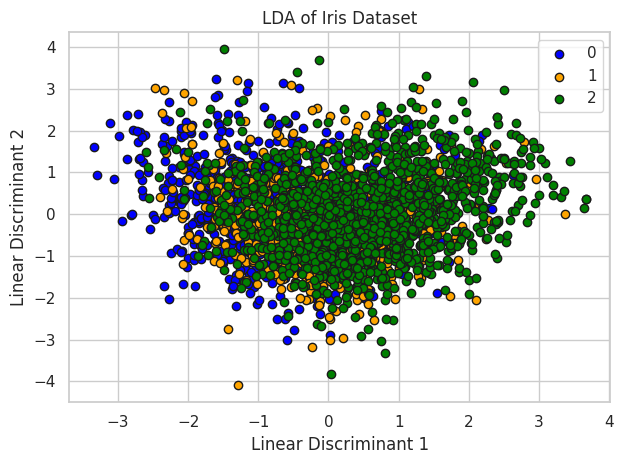

In [41]:
# Apply LDA with 2 components for visualization (can be changed)
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_train, y_train)

targets = list(set(y_train))
colors = ['blue', 'orange', 'green']

for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    plt.scatter(X_lda[indices_to_keep, 0], X_lda[indices_to_keep, 1], c=color, label=target, edgecolor='k')

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('LDA of Iris Dataset')
plt.legend()
plt.tight_layout()

plt.show()

## Model Selection

There are a variety of possible models that could be deployed for this problem. The following section attempts to compare different models and their performance for the task.

In [42]:
def train_and_compare_classifiers(X, y, classifiers, title="Comparison of Classifier Accuracies"):
    accuracies = {}
    std_devs = {}
    
    for clf_name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=5)
        accuracies[clf_name] = scores.mean()
        std_devs[clf_name] = scores.std()

    # Plotting accuracies
    plt.figure(figsize=(10, 6))
    bars = plt.bar(accuracies.keys(), accuracies.values(), yerr=list(std_devs.values()), capsize=5, alpha=0.7)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim([0, 1])
    plt.tight_layout()

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.3f}', ha='center', va='bottom')

    plt.show()

### _Setup 5 potential classifier types_

For all classifier types, having a normalization applied to the features tends to prevent a single feature from dominating the loss function classifier. Thus a `StandardScaler` is applied to the data within a Pipeline, to normalize the data.

The tested classifiers are: Support Vector Machine, KNN, Random Forest, Naive Bayes and Logistic Regression. Of these, the Support Vector Machine has the best empirical performance.

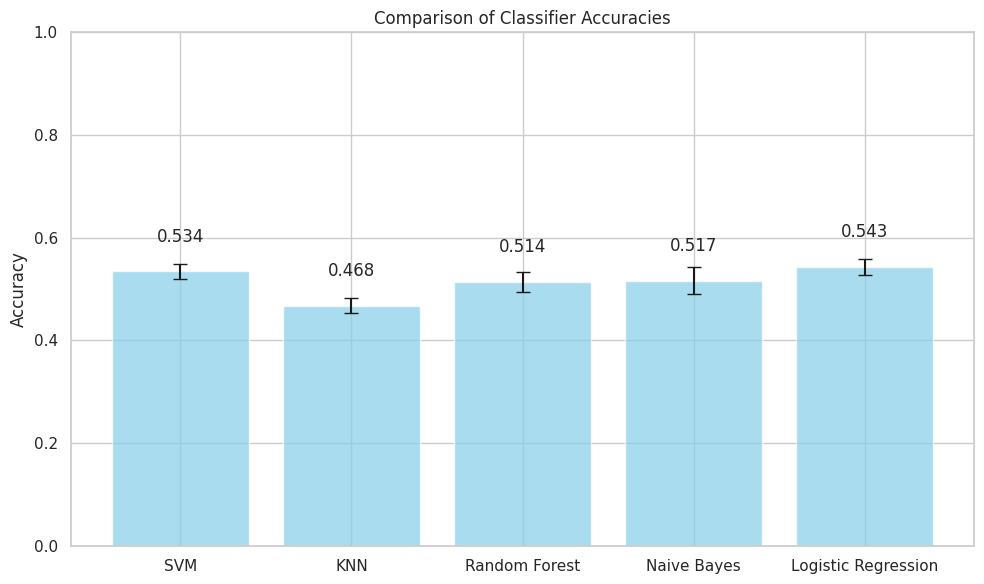

In [43]:
classifiers = {
    'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC())]),
    'KNN': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', KNeighborsClassifier())]),
    'Random Forest': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier())]),
    'Naive Bayes': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', GaussianNB())]),
    'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression())]),
}

train_and_compare_classifiers(X_train, y_train, classifiers)

### _Dimensionality Reduction_
Since there are many features, and many of those features are correlated, there might be opportunites where dimensionality reduction could improve the performance of the model. Since the Support Vector Machine is seen to have the best classifier performance, it is chosen for further investigation.

A standard `SVC` is compared to an `SVC` with Principal Component Analysis appled, and another with Linear Discriminant Analysis applied, as a preprocessing step. A `Pipeline` is used to prevent data leakage.

An LDA appears to provide a marginal but probably insignificant benefit.

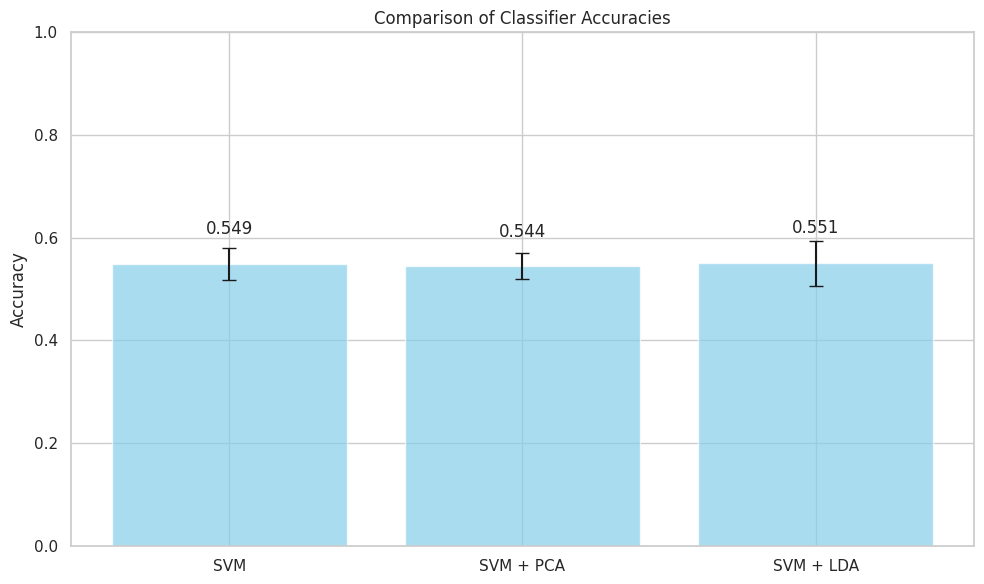

In [20]:
classifiers = {
    'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC())]),
    'SVM + PCA': Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=2)), # There are only 3 classes
            ('classifier', SVC())]),
    'SVM + LDA': Pipeline([
            ('scaler', StandardScaler()),
            ('lda', LDA(n_components=2)),
            ('classifier', SVC())]),
}

train_and_compare_classifiers(X_train, y_train, classifiers)

### _Sequential Feature Selection_
Since there are still many correlated features, and dimensionality reduction did not help, sequential feature selection is used to find optimal features to include. Mean validation accuracy peaks at **5 features**, and the 5 selected features are used in the final model.

Using 1 features, mean score: 0.5273336072934265
Using 2 features, mean score: 0.5604660365584525
Using 3 features, mean score: 0.561571008934143
Using 4 features, mean score: 0.5610246107483677
Using 5 features, mean score: 0.5615725309346604
Using 6 features, mean score: 0.559916594371642
Using 7 features, mean score: 0.5577096936212957
Using 8 features, mean score: 0.559919638372677
Using 9 features, mean score: 0.5593686741853492
Using 10 features, mean score: 0.5577096936212957


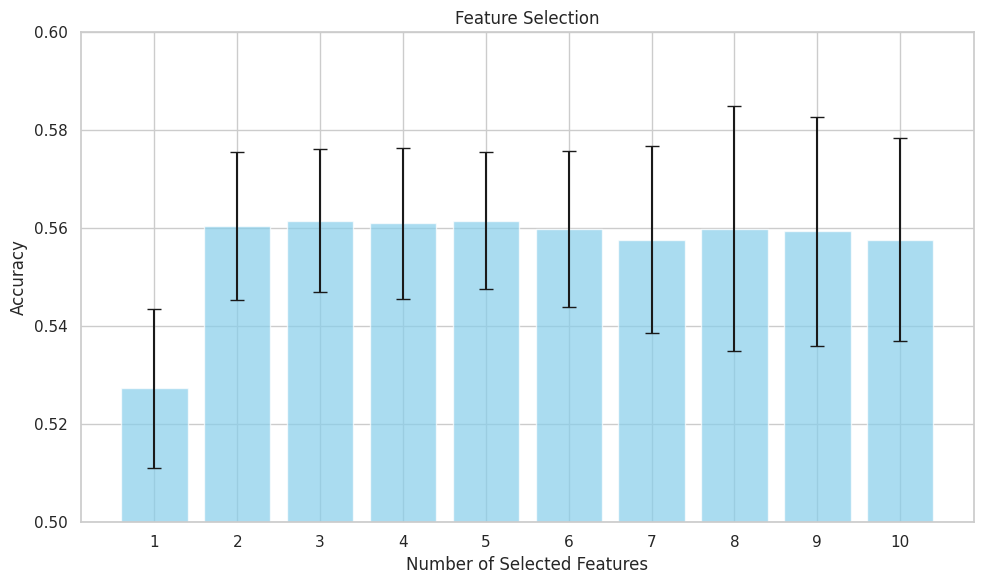

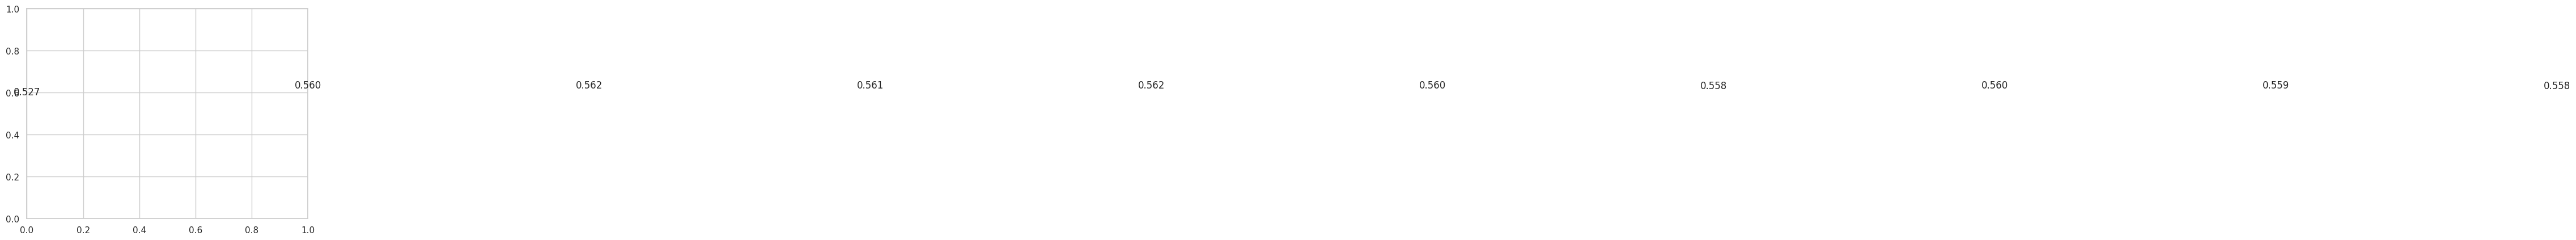

In [37]:
clf = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC())])

accuracies = {}
std_devs = {}

for i in range(1, 11):
    sfs_forward = SequentialFeatureSelector(
        clf, n_features_to_select=i, direction="forward", n_jobs=4
    ).fit(X_train, y_train)

    selected_features = sfs_forward.get_support()
    X_train_selected = X_train[:, selected_features]

    scores = cross_val_score(clf, X_train_selected, y_train, cv=5)
    accuracies[f"{i}"] = scores.mean()
    std_devs[f"{i}"] = scores.std()

    print(f"Using {i} features, mean score: {scores.mean()}")

# Plotting accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracies.keys(), accuracies.values(), yerr=list(std_devs.values()), capsize=5, alpha=0.7)
plt.ylabel('Accuracy')
plt.xlabel('Number of Selected Features')
plt.title('Feature Selection')
plt.ylim([0.5, 0.6])
plt.tight_layout()
plt.show()

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.3f}', ha='center', va='bottom')
    

# Model Training and Validation

In the full training run, the following setup will be used.

* The training data will be all the data before the **2020** league.
* The test data will be the **2020** league and onwards.
* Forward Sequential Feature Selection will be done to identify the top 5 features for the model.
* All features will be scaled to zero mean and unit variance
* A support vector machine (`SVC`) will be used as the model

In [48]:
X_train = df_features_train[[*home_columns, *away_columns, *team_columns]].values
y_train = df_features_train[['FTRLabel']].values.ravel()

X_test = df_features_test[[*home_columns, *away_columns, *team_columns]].values
y_test = df_features_test[['FTRLabel']].values.ravel()

print(f"Training set size is {X_train.shape}")
print(f"Test set size is {X_test.shape}")

Training set size is (2107, 26)
Test set size is (1170, 26)


In [ ]:
# Define the pipeline
clf = Pipeline([('scaler', StandardScaler()), ('classifier', SVC())])

In [49]:
# Sequential Feature Selection, select 5
sfs_forward = SequentialFeatureSelector(
    clf, n_features_to_select=5, direction="forward", n_jobs=4
).fit(X_train, y_train)

selected_features = sfs_forward.get_support()
X_train_selected = X_train[:, selected_features]

feature_names = np.array([*home_columns, *away_columns, *team_columns])
print(f"The selected features are {feature_names[selected_features]}")

The selected features are ['FTHG' 'HST' 'FTAG' 'AS' 'HAT']


In [64]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"Cross validation accuracy of the pipeline is {scores.mean()}. Std dev: {scores.std()}")

Cross validation accuracy of the pipeline is 0.5458117098760568. Std dev: 0.014123250670931724


# Results

Test accuracy of the pipeline is 0.5282051282051282
[[0.56467662 0.         0.43532338]
 [0.39473684 0.         0.60526316]
 [0.22111554 0.         0.77888446]]


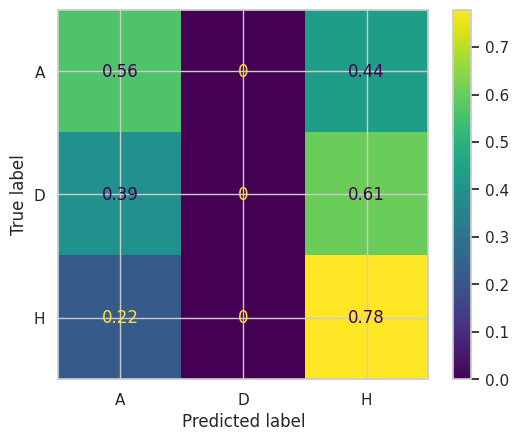

In [72]:
test_score = pipeline.fit(X_train, y_train).score(X_test, y_test)
print(f"Test accuracy of the pipeline is {test_score}")

disp = ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test,
    display_labels=result_encoder.classes_,
    normalize="true",
)
print(disp.confusion_matrix)

# Final Predictions on Test Set

## Generate features

In [78]:
# Setup variables to store the computed features
test_feature_list = []
test_feature_columns = ['Date', 'League', 'HomeTeam', 'AwayTeam', *home_columns, *away_columns, *team_columns]

# Name map because test team names are different from training team names
name_map = {
    'Man City': 'Man City',
    'Arsenal': 'Arsenal',
    'Liverpool': 'Liverpool',
    'Man Utd': 'Man United',
    'Spurs': 'Tottenham',
    'Aston Villa': 'Aston Villa',
    'Chelsea': 'Chelsea',
    'Newcastle': 'Newcastle',
    'West Ham': 'West Ham',
    'Everton': 'Everton',
    'Nottingham Forest': "Nott'm Forest",
    'Brighton': 'Brighton',
    'Wolves': 'Wolves',
    'Fulham': 'Fulham',
    'Crystal Palace': 'Crystal Palace',
    'Brentford': 'Brentford',
    'AFC Bournemouth': 'Bournemouth',
    'Burnley': 'Burnley',
    'Cardiff City': 'Cardiff',
    'Huddersfield Town': 'Huddersfield',
    'Hull City': 'Hull',
    'Leeds United': 'Leeds',
    'Leicester City': 'Leicester',
    'Luton Town': 'Luton',
    'Middlesbrough': 'Middlesbrough',
    'Norwich City': 'Norwich',
    'Queens Park Rangers': 'QPR',
    'Reading': 'Reading',
    'Sheff Utd': 'Sheffield United',
    'Southampton': 'Southampton',
    'Stoke City': 'Stoke',
    'Sunderland': 'Sunderland',
    'Swansea City': 'Swansea',
    'Watford': 'Watford',
    'West Bromwich Albion': 'West Brom',
    'Wigan Athletic': 'Wigan'
}

for index in range(len(df_test)):
    year = 2024
    row = df_test.iloc[index]
    hometeam = name_map[row['HomeTeam']]
    awayteam = name_map[row['AwayTeam']]
    
    home =  precomputed_features[hometeam]['Home']
    home = home[home['Date'] < row['Date']]
    if home.empty:
        continue
    else:
        home = home.iloc[-1]

    # Check if ratings exist for the year
    home_team = df_teams[df_teams['Team'] == hometeam]
    home_team = home_team[home_team['Year'] == year]

    # Else use the latest one
    if home_team.empty:
        home_team = df_teams[df_teams['Team'] == hometeam]
        home_team = home_team[home_team['Year'] < year]
        # Else use sensible default team stats
        if home_team.empty:
            home_team = pd.DataFrame([[60, 60, 60, 60, 1]], columns=team_columns_single) # Defaults
            home_team = home_team.iloc[0]
        else:
            home_team = home_team.iloc[0]
    else:
        home_team = home_team.iloc[0]

    away =  precomputed_features[awayteam]['Away']
    away = away[away['Date'] < row['Date']]
    if away.empty:
        continue
    else:
        away = away.iloc[-1]

    # Check if ratings exist for the year
    away_team = df_teams[df_teams['Team'] == awayteam]
    away_team = away_team[away_team['Year'] == year]

    # Else use the latest one
    if away_team.empty:
        away_team = df_teams[df_teams['Team'] == awayteam]
        away_team = away_team[away_team['Year'] < year]
        if away_team.empty:
            # Else use sensible default team stats
            away_team = pd.DataFrame([[60, 60, 60, 60, 1]], columns=team_columns_single) # Defaults
            away_team = away_team.iloc[0]
        else:
            away_team = away_team.iloc[0]
    else:
        away_team = away_team.iloc[0]

    test_feature_list.append([row['Date'], year, hometeam, awayteam,
                        *home[home_columns], *away[away_columns],
                        *home_team[team_columns_single], *away_team[team_columns_single]])

test_df_features = pd.DataFrame(test_feature_list, columns=test_feature_columns)
test_df_features.tail()

,Date,League,HomeTeam,AwayTeam,FTHG,HTHG,HS,HST,HF,HC,...,HOA,HAT,HMD,HDF,HCW,AOA,AAT,AMD,ADF,ACW
5,03-Feb-24,2024,Chelsea,Wolves,1.302517,0.544017,15.148462,4.932810,10.299926,6.330669,...,78,79,79,33,24.36,77,77,76,28,26.27
6,03-Feb-24,2024,Everton,Tottenham,1.055801,0.487430,13.270029,4.839825,10.043847,5.353699,...,79,76,75,28,26.27,81,81,79,33,23.91
7,03-Feb-24,2024,Man United,West Ham,1.716196,0.694340,16.348456,5.823621,10.593463,6.225936,...,80,83,78,33,26.73,78,79,78,33,28.00
8,03-Feb-24,2024,Newcastle,Luton,1.819082,0.865762,15.427445,5.488593,10.586503,6.180627,...,80,80,81,32,27.64,71,73,72,29,26.73
9,03-Feb-24,2024,Sheffield United,Aston Villa,0.767166,0.429645,9.779618,3.220571,12.149061,4.410276,...,72,74,73,33,26.27,82,80,79,33,25.82


## Train on all the data and make predictions

In [81]:
X = df_features[[*home_columns, *away_columns, *team_columns]].values
y = df_features[['FTRLabel']].values.ravel()

X_test = test_df_features[[*home_columns, *away_columns, *team_columns]].values

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

y_pred = pipeline.fit(X,y).predict(X_test)
y_pred = result_encoder.inverse_transform(y_pred)
print(y_pred)

['H' 'H' 'A' 'H' 'A' 'H' 'A' 'H' 'H' 'A']


## Store to the csv in desired format

In [83]:
df_test['FTR'] = y_pred
df_test.to_csv('epl-test-populated.csv', index=False)
df_test.head()

,Date,HomeTeam,AwayTeam,FTR
0,03-Feb-24,AFC Bournemouth,Nottingham Forest,H
1,03-Feb-24,Arsenal,Liverpool,H
2,03-Feb-24,Brentford,Man City,A
3,03-Feb-24,Brighton,Crystal Palace,H
4,03-Feb-24,Burnley,Fulham,A


# References

- [Forecasting football](https://mercurius.io/en/learn/predicting-forecasting-football)
- [Prediction of football match results with Machine Learning](https://www.sciencedirect.com/science/article/pii/S1877050922007955)
    - You have to account for home advantage in the base rates 
    - https://sofifa.com/ for scores on player ability and the scores on team ability
- [Predicting Football Matches Results using Bayesian Networks for English Premier League (EPL)](https://iopscience.iop.org/article/10.1088/1757-899X/226/1/012099)
- [Predicting Football Results Using Machine Learning Techniques](https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/computing/public/1718-ug-projects/Corentin-Herbinet-Using-Machine-Learning-techniques-to-predict-the-outcome-of-profressional-football-matches.pdf)
- [Forecasting football match results using a player rating based model](https://www.sciencedirect.com/science/article/pii/S016920702300033X)
    - Use historical betting odds as the predictive label
    - 
- [Forecasting football matches by predicting match statistics](https://content.iospress.com/articles/journal-of-sports-analytics/jsa200462)
- Datasets
    - https://www.kaggle.com/datasets/hugomathien/soccer

- https://www.football-data.co.uk/ratings.pdf
- https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting/
- https://opisthokonta.net/?p=1548